# HOMEWORK PART 1

1. Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). Try also bagging the DMD to improve the results. See: https://github.com/duqbo/optdmd (MATLAB) and https://github.com/kunert/py-optDMD (Python)

2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. Try also bagging the DMD to improve the results.

3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d.

4. Find the best fit nonlinear, dynamical systems model to the data using bagging sparse regression SINDy (See: https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
from scipy.linalg import hankel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from scipy import integrate
from Utility.FunctionsDMD import DMD
import matlab.engine

plt.style.use('science')

In [2]:
path = os.path.join("..", "Data", "Lynx-Snowshoe.csv")

data = pd.read_csv(path)

yr = data['Year']
sh = data['Snowshoe Hare Pelts(thousands)']
cl = data['Canadian Lynx Pelts(thousands)']

dt = 2

time = np.arange(0, max(yr) - min(yr) + dt, dt)

data.head()

,Year,Snowshoe Hare Pelts(thousands),Canadian Lynx Pelts(thousands)
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


# Request  n° 1

- Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). \
    Try also bagging the DMD to improve the results. See: 
    - https://github.com/duqbo/optdmd (MATLAB) 
    - https://github.com/kunert/py-optDMD (Python)

In [3]:
# Interpolation of the data series, the interpolation with the B-Splne function from SciPy have reasulted in some values lower than 0 replaced here with 1

sh_int = splrep(time, sh)
cl_int = splrep(time, cl)

dt = 0.01

yr_new = np.arange(min(yr), max(yr) + dt, dt)

t_new = np.arange(0, max(yr) - min(yr) + dt, dt)

sh_new = splev(t_new, sh_int)
tmp = sh_new <= 1
sh_new[tmp] = 1

cl_new = splev(t_new, cl_int)
tmp = cl_new <= 1
cl_new[tmp] = 1

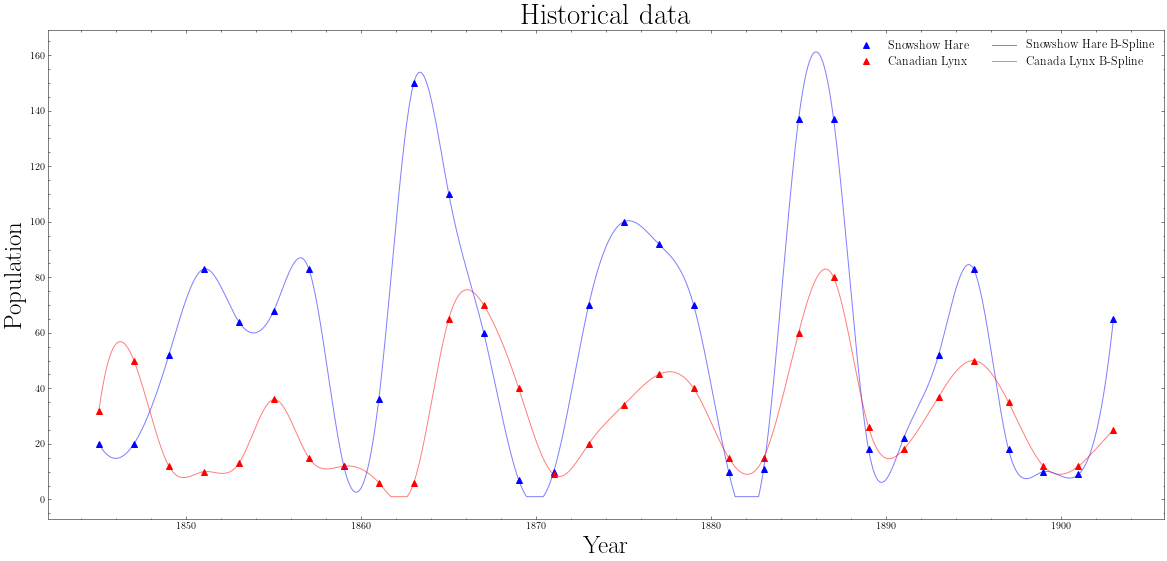

In [4]:
fig = plt.figure(figsize=(20, 9))

plt.plot(yr, sh, '^', linewidth='2', color='blue')
plt.plot(yr, cl, '^', linewidth='2', color='red') 
plt.plot(yr_new, sh_new, color='blue', alpha= 0.5)
plt.plot(yr_new, cl_new, color='red', alpha = 0.5)
plt.title('Historical data', fontsize = 29)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Population', fontsize = 25)
plt.legend(['Snowshow Hare', 'Canadian Lynx', 'Snowshow Hare B-Spline', 'Canada Lynx B-Spline'], fontsize = 12, ncol=2)

fig.savefig('Figures/population_data.pdf', format='pdf', dpi=1200)
plt.show()

# DMD on the real data-set

In [5]:
tmp_data = np.vstack((sh, cl))
X = tmp_data[:, :-1]
Xshift = tmp_data[:, 1:]

In [6]:
r = 2

Phi, Lambda, b = DMD(X,Xshift,r)

dt = time[1] - time[0]

logLambda = np.copy(Lambda)

for i in range(len(logLambda)):
    for j in range(len(logLambda[0])):
        if(logLambda[i,j] != 0):
            logLambda[i,j] = np.log(logLambda[i,j]) / dt

x_dmd = np.zeros((r, len(time)))

for i in range(len(time)):
    s1 = logLambda * time[i]
    s2 = np.diag(np.exp(s1))
    s3 = b * s2
    s4 = Phi @ s3
    x_dmd[:, i] = s4

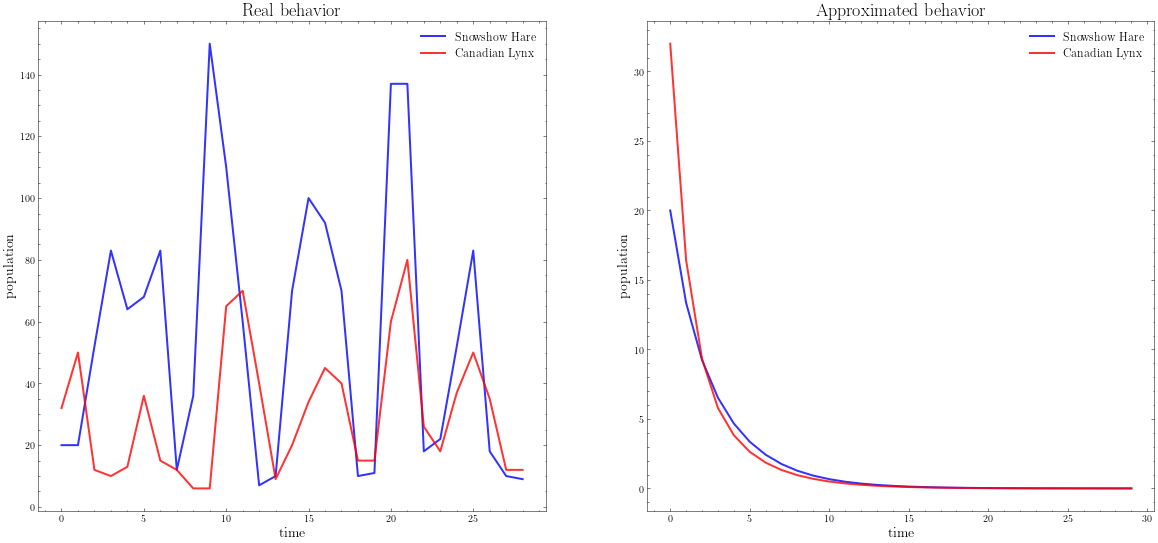

In [7]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/DMD_realset.pdf', format='pdf', dpi=1200)
plt.show()

# BOP-DMD on the real data-set

In [8]:
eng = matlab.engine.start_matlab()

In [9]:
r = 2
agg = os.path.join(os.getcwd(), 'Utility', 'MatlabBOPDMD')
eng.addpath(agg, nargout=0)

imode = 1
xxx = matlab.double(tmp_data.tolist())
ttt = matlab.double(time.tolist())

w, e, b, atilde, u, afull = eng.optdmd(xxx, ttt, r, imode, nargout=6) 

step 1 err 8.979701e+04 lambda 3.333333e-01
step 2 err 8.762333e+04 lambda 1.111111e-01
step 3 err 8.526545e+04 lambda 3.703704e-02
step 4 err 7.944407e+04 lambda 1.234568e-02
step 5 err 7.312401e+04 lambda 4.115226e-03
step 6 err 7.297708e+04 lambda 7.962926e-03
step 7 err 6.350257e+04 lambda 2.654309e-03
step 8 err 5.648097e+04 lambda 3.479055e+02
step 9 err 3.214752e+04 lambda 1.159685e+02
step 10 err 3.076261e+04 lambda 6.842359e+01
step 11 err 3.050780e+04 lambda 2.280786e+01
step 12 err 3.047648e+04 lambda 1.824629e+02
step 13 err 3.024937e+04 lambda 6.082097e+01
step 14 err 3.016030e+04 lambda 5.183192e+01
step 15 err 3.008780e+04 lambda 1.727731e+01
step 16 err 3.008612e+04 lambda 5.759103e+00
step 17 err 3.008612e+04 lambda 3.342436e+00
step 18 err 3.008612e+04 lambda 2.487790e+00
step 19 err 3.008612e+04 lambda 1.852343e+00
step 20 err 3.008612e+04 lambda 1.378904e+00
step 21 err 3.008612e+04 lambda 1.029963e+00
stall detected: residual reduced by less than 1.000000e-12 times

In [10]:
eng.quit()

In [14]:
w = np.array(w)
e = np.array(e)
b = np.array(b)

t = np.linspace(time[0], time[-1] + 150)

diagb = np.array([[b[0,0], 0],
                [0, b[1,0]]])

term1 = w * diagb
term2 = np.exp(e * t)

x_dmd = np.dot(term1, term2)

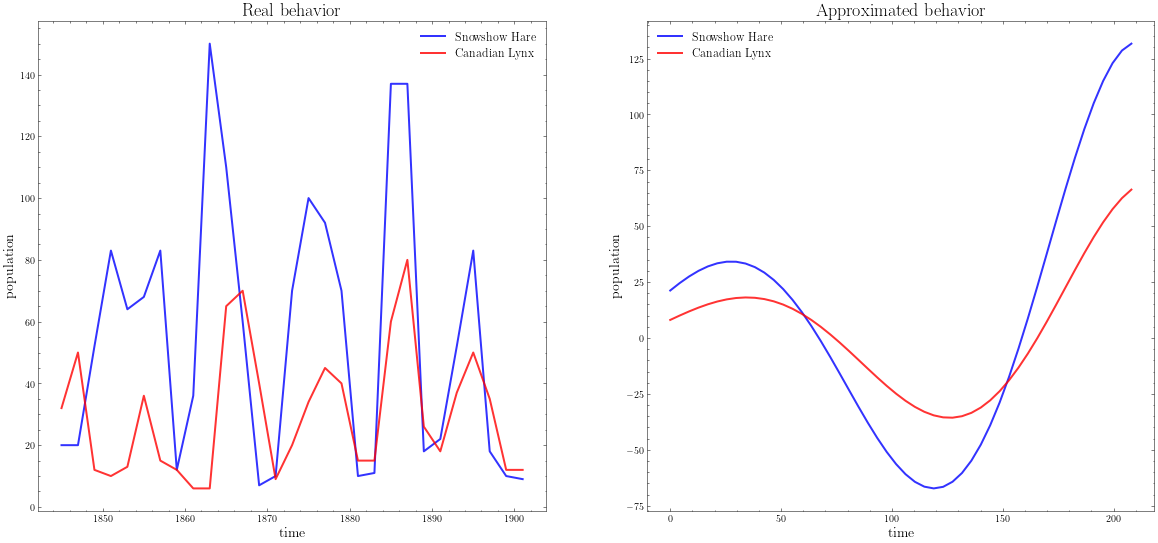

In [15]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(t, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(t, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/BOPDMD_realset.pdf', format='pdf', dpi=1200)
plt.show()

# DMD on the augmented data-set

In [ ]:
# Repeting the same procedure with the interpolated data

tmp_data = np.vstack((sh_new, cl_new))

X = tmp_data[:, :-1]
dX = tmp_data[:, 1:]

In [ ]:
r = 2
Phi, Lambda, b = DMD(X, dX, r)

dt = t_new[1] - t_new[0]
logLambda = np.copy(Lambda)

for i in range(len(logLambda)):
    for j in range(len(logLambda[0])):
        if(logLambda[i,j] != 0):
            logLambda[i,j] = np.log(logLambda[i,j]) / dt

x_dmd = np.zeros((r, len(t_new)))#, dtype=omega.dtype)
for i in range(len(t_new)):
    s1 = logLambda * t_new[i]
    s2 = np.diag(np.exp(s1))
    s3 = b * s2
    s4 = Phi @ s3
    x_dmd[:, i] = s4

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr_new[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr_new, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/DMD_augmentedset.pdf', format='pdf', dpi=1200)
plt.show()

# BOP-DMD on the augmented data-set

In [ ]:
eng = matlab.engine.start_matlab()

In [ ]:
agg = os.path.join(os.getcwd(), 'Utility', 'MatlabBOPDMD')
eng.addpath(agg, nargout=0)

imode = 1
xxx = matlab.double(tmp_data.tolist())
ttt = matlab.double(t_new.tolist())

w, e, b, atilde, u, afull = eng.optdmd(xxx, ttt, r, imode, nargout=6) 

In [ ]:
eng.quit()

In [ ]:
w = np.array(w)
e = np.array(e)
b = np.array(b)
diagb = np.array([[b[0,0], 0],
                [0, b[1,0]]])
term1 = w * diagb
term2 = np.exp(e * ttt)

x_dmd = term1 @ term2

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
fig.savefig('Figures/BOPDMD_augset.pdf', format='pdf', dpi=1200)
plt.show()

# Request n° 2
- Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. 
    - Try also bagging the DMD to improve the results.

If you are looking for some inspiration looks here: 
- http://www.node99.org/tutorials/ar/

In [ ]:
# Initialize variables for the time delay

data = np.vstack((sh_new, cl_new))

t_start = 100
t_window = t_start
x_train = np.ones((100,)) * yr_new[t_start]
y_train = np.arange(0, 150, 150 / 100)